In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [53]:
from tqdm.notebook import tqdm

In [2]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [3]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [4]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

In [46]:
class VAE:
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.optimizer = keras.optimizers.Adam()

    def __call__(self,x):
        return x
        
    def step(self, data):
        with tf.GradientTape() as e_tape,tf.GradientTape() as d_tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        
        grads = e_tape.gradient(total_loss, self.encoder.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.encoder.trainable_weights))
        
        grads = d_tape.gradient(total_loss, self.decoder.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.decoder.trainable_weights))
        
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }
    

In [47]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)

In [66]:
epochs = 50
batch_size = 100

In [67]:
batches = mnist_digits.reshape(-1,batch_size,28,28,1)

In [68]:
for epoch in range(epochs):
    for i,batch in tqdm(enumerate(batches),total=len(batches)):
        loss = vae.step(batch)
    loss['epoch'] = epoch
    print ("epoch : {epoch} loss : {loss} reconstruction_loss:{reconstruction_loss} kl_loss:{kl_loss}".format(**loss))


epoch : 0 loss : 148.9884490966797 reconstruction_loss:145.01014709472656 kl_loss:3.978301763534546



epoch : 1 loss : 147.9390869140625 reconstruction_loss:144.02146911621094 kl_loss:3.9176185131073



epoch : 2 loss : 148.09075927734375 reconstruction_loss:144.1575927734375 kl_loss:3.933159112930298



epoch : 3 loss : 148.7159423828125 reconstruction_loss:144.81570434570312 kl_loss:3.900242328643799



epoch : 4 loss : 147.60914611816406 reconstruction_loss:143.69105529785156 kl_loss:3.9180965423583984



epoch : 5 loss : 147.8363037109375 reconstruction_loss:143.95458984375 kl_loss:3.881721258163452



epoch : 6 loss : 148.1873779296875 reconstruction_loss:144.3017120361328 kl_loss:3.885662317276001



epoch : 7 loss : 147.91531372070312 reconstruction_loss:144.06436157226562 kl_loss:3.8509528636932373



epoch : 8 loss : 147.90399169921875 reconstruction_loss:144.05535888671875 kl_loss:3.8486390113830566



epoch : 9 loss : 147.98622131347656 reconstruction_loss:144.1230010986328 kl_loss:3.863215446472168



epoch : 10 loss : 148.30499267578125 reconstruction_loss:144.5188446044922 kl_loss:3.7861521244049072



epoch : 11 loss : 148.32618713378906 reconstruction_loss:144.4959259033203 kl_loss:3.830253839492798



epoch : 12 loss : 147.5306396484375 reconstruction_loss:143.7422332763672 kl_loss:3.7884116172790527



epoch : 13 loss : 148.041015625 reconstruction_loss:144.2921905517578 kl_loss:3.7488293647766113



epoch : 14 loss : 147.56431579589844 reconstruction_loss:143.78919982910156 kl_loss:3.775117874145508



epoch : 15 loss : 148.26129150390625 reconstruction_loss:144.4828338623047 kl_loss:3.778458833694458



epoch : 16 loss : 148.08216857910156 reconstruction_loss:144.3062286376953 kl_loss:3.77593994140625



epoch : 17 loss : 147.30172729492188 reconstruction_loss:143.5648956298828 kl_loss:3.7368249893188477



epoch : 18 loss : 148.01409912109375 reconstruction_loss:144.1927490234375 kl_loss:3.821347236633301



epoch : 19 loss : 147.67758178710938 reconstruction_loss:143.91490173339844 kl_loss:3.7626781463623047



epoch : 20 loss : 147.3872833251953 reconstruction_loss:143.59909057617188 kl_loss:3.7881972789764404



epoch : 21 loss : 147.37173461914062 reconstruction_loss:143.60079956054688 kl_loss:3.770930767059326



epoch : 22 loss : 147.42881774902344 reconstruction_loss:143.665771484375 kl_loss:3.763045072555542



epoch : 23 loss : 147.96182250976562 reconstruction_loss:144.20152282714844 kl_loss:3.760294198989868



epoch : 24 loss : 147.22406005859375 reconstruction_loss:143.41754150390625 kl_loss:3.8065178394317627



epoch : 25 loss : 146.75303649902344 reconstruction_loss:143.02684020996094 kl_loss:3.726199150085449



epoch : 26 loss : 146.8319549560547 reconstruction_loss:143.02728271484375 kl_loss:3.804666757583618



epoch : 27 loss : 146.79678344726562 reconstruction_loss:143.0250701904297 kl_loss:3.7717063426971436



epoch : 28 loss : 146.1600341796875 reconstruction_loss:142.38125610351562 kl_loss:3.778782367706299



epoch : 29 loss : 146.91738891601562 reconstruction_loss:143.1542205810547 kl_loss:3.7631640434265137



epoch : 30 loss : 147.84454345703125 reconstruction_loss:144.04299926757812 kl_loss:3.80153751373291



epoch : 31 loss : 146.4800262451172 reconstruction_loss:142.716064453125 kl_loss:3.7639670372009277



epoch : 32 loss : 147.49002075195312 reconstruction_loss:143.6924591064453 kl_loss:3.7975664138793945



epoch : 33 loss : 146.14004516601562 reconstruction_loss:142.35313415527344 kl_loss:3.7869162559509277



epoch : 34 loss : 148.66954040527344 reconstruction_loss:144.84713745117188 kl_loss:3.8224072456359863



epoch : 35 loss : 148.8881072998047 reconstruction_loss:145.090576171875 kl_loss:3.7975378036499023



epoch : 36 loss : 148.86074829101562 reconstruction_loss:145.06346130371094 kl_loss:3.797285795211792



epoch : 37 loss : 148.76531982421875 reconstruction_loss:145.00291442871094 kl_loss:3.7624123096466064



epoch : 38 loss : 147.5594482421875 reconstruction_loss:143.75831604003906 kl_loss:3.801126480102539



epoch : 39 loss : 147.2931365966797 reconstruction_loss:143.46133422851562 kl_loss:3.831796646118164



epoch : 40 loss : 147.480712890625 reconstruction_loss:143.70387268066406 kl_loss:3.776841163635254



epoch : 41 loss : 147.16189575195312 reconstruction_loss:143.38143920898438 kl_loss:3.7804501056671143



epoch : 42 loss : 146.72885131835938 reconstruction_loss:142.95506286621094 kl_loss:3.7737863063812256



epoch : 43 loss : 147.8111114501953 reconstruction_loss:143.97836303710938 kl_loss:3.832742214202881



epoch : 44 loss : 146.95712280273438 reconstruction_loss:143.1992645263672 kl_loss:3.757863759994507



epoch : 45 loss : 146.7062530517578 reconstruction_loss:142.93826293945312 kl_loss:3.767996311187744



epoch : 46 loss : 147.20901489257812 reconstruction_loss:143.41563415527344 kl_loss:3.7933766841888428



epoch : 47 loss : 148.05397033691406 reconstruction_loss:144.26504516601562 kl_loss:3.7889251708984375



epoch : 48 loss : 147.5849609375 reconstruction_loss:143.76585388183594 kl_loss:3.8191025257110596



epoch : 49 loss : 147.1386260986328 reconstruction_loss:143.3426055908203 kl_loss:3.7960152626037598


In [61]:
import matplotlib.pyplot as plt

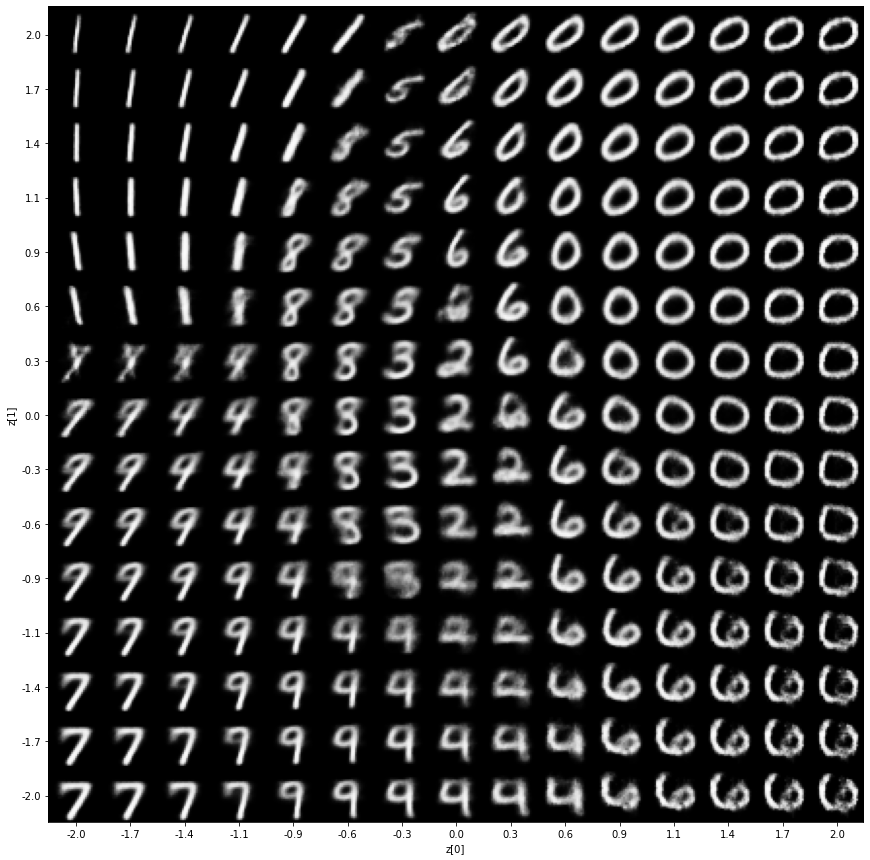

In [70]:
def plot_latent(encoder, decoder):
    # display a n*n 2D manifold of digits
    n = 15
    digit_size = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder)